In [1]:
# Libraries
import numpy as np
import math
from scipy.linalg import block_diag
from matplotlib import pyplot as plt
import copy

In [2]:
# Transformation rules for adjacency matrix, Z

def transform_Z(symplectic, Z):
    A = symplectic[:int(np.shape(symplectic)[0]/2),:int(np.shape(symplectic)[0]/2)]
    B = symplectic[int(np.shape(symplectic)[0]/2):,:int(np.shape(symplectic)[0]/2)]
    C = symplectic[:int(np.shape(symplectic)[0]/2),int(np.shape(symplectic)[0]/2):]
    D = symplectic[int(np.shape(symplectic)[0]/2):,int(np.shape(symplectic)[0]/2):]

    return (C + D@Z)@np.linalg.inv(A + B@Z)

# Mode transformation from H-graph into Approximate CV Cluster state

def identify_bipartition(Z):
    modes = list(np.arange(int(np.shape(Z)[0])))
    for mode in modes:
        test_modes = copy.deepcopy(modes)
        test_modes.remove(mode)
        for test_mode in test_modes:
            if abs(Z[mode][test_mode]) > 0.1 or abs(Z[test_mode][mode]) > 0.1: #MAY NEED TO LOWER THESE LIMITS FOR LOW SQUEEZING
                modes.remove(test_mode)
    return modes

def generate_S_h2c(modes):
    S_h2c = np.identity(num_modes*4)
    for mode in modes:
        S_h2c[mode][mode] = 0
        S_h2c[mode][mode+2*num_modes] = -1
        S_h2c[mode+2*num_modes][mode] = 1
        S_h2c[mode+2*num_modes][mode+2*num_modes] = 0

    return S_h2c

# Symplectic matrix for EPR state generation from two initially squeezed modes

def epr_symplectic():

    #Delay on B mode

    S_phase_delay = np.zeros((num_modes*4, num_modes*4))

    for i in range(num_modes):
        S_phase_delay[i*2,i*2] = 1
        S_phase_delay[(num_modes+i)*2,(num_modes+i)*2] = 1
        S_phase_delay[i*2+1,(num_modes+i)*2+1] = -1
        S_phase_delay[(num_modes+i)*2+1,i*2+1] = 1

    #Beamsplitter for EPR state generation

    S_bs0 = np.array([])

    for i in range(num_modes):
        bs_block = np.array([[1/np.sqrt(2),-1/np.sqrt(2)],[1/np.sqrt(2),1/np.sqrt(2)]])
        if i == 0:
            S_bs0 = np.block([
                [bs_block, np.zeros((2,2))],
                [np.zeros((2,2)), bs_block]
            ])
        else:
            size = np.shape(S_bs0)
            S_bs0 = np.block([
                [S_bs0[:int(size[0]/2),:int(size[0]/2)],np.zeros((int(size[1]/2),2)), S_bs0[int(size[0]/2):,:int(size[0]/2)],np.zeros((int(size[1]/2),2))],
                [np.zeros((2,int(size[0]/2))), bs_block, np.zeros((2,int(size[0]/2))), np.zeros((2,2))],
                [S_bs0[int(size[0]/2):,:int(size[0]/2)], np.zeros((int(size[1]/2),2)), S_bs0[int(size[0]/2):,int(size[0]/2):], np.zeros((int(size[1]/2),2))],
                [np.zeros((2,int(size[0]/2))), np.zeros((2,2)), np.zeros((2,int(size[0]/2))), bs_block]
            ])

    return S_bs0@S_phase_delay

# Symplectic matrix for cluster state generation from an EPR state

def cluster_symplectic(bs_1=0, bs_2=0, bs_3=0):

    #Beamsplitter for 1D cluster generation

    if bs_1 == 0:

        S_bs1 = np.diag(np.ones(num_modes*4))

    else:

        bs1_block = np.diag(np.ones(num_modes*2))

        for i in range(num_modes):
            if 2*i+1+(2*bs_1-1) < num_modes*2:
                bs1_block[2*i+1,2*i+1] = 1/np.sqrt(2)
                bs1_block[2*i+1,2*i+1+(2*bs_1-1)] = -1/np.sqrt(2)
                bs1_block[2*i+1+(2*bs_1-1),2*i+1] = 1/np.sqrt(2)
                bs1_block[2*i+1+(2*bs_1-1),2*i+1+(2*bs_1-1)] = 1/np.sqrt(2)

        S_bs1 = np.block([[bs1_block, np.zeros((num_modes*2, num_modes*2))],[np.zeros((num_modes*2, num_modes*2)), bs1_block]]) 

    #Beamsplitter for 2D cluster generation

    if bs_2 == 0:

        S_bs2 = np.diag(np.ones(num_modes*4))

    else:

        bs2_block = np.diag(np.ones(num_modes*2))

        for i in range(num_modes):
            if 2*i+1+(2*bs_2-1) < num_modes*2:
                bs2_block[2*i+1,2*i+1] = 1/np.sqrt(2)
                bs2_block[2*i+1,2*i+1+(2*bs_2-1)] = -1/np.sqrt(2)
                bs2_block[2*i+1+(2*bs_2-1),2*i+1] = 1/np.sqrt(2)
                bs2_block[2*i+1+(2*bs_2-1),2*i+1+(2*bs_2-1)] = 1/np.sqrt(2)

        S_bs2 = np.block([[bs2_block, np.zeros((num_modes*2, num_modes*2))],[np.zeros((num_modes*2, num_modes*2)), bs2_block]])  

    #Beamsplitter for 3D cluster generation

    if bs_3 == 0:

        S_bs3 = np.diag(np.ones(num_modes*4))
    
    else:

        bs3_block = np.diag(np.ones(num_modes*2))

        for i in range(num_modes):
            if 2*i+1+(2*bs_3-1) < num_modes*2:
                bs3_block[2*i+1,2*i+1] = 1/np.sqrt(2)
                bs3_block[2*i+1,2*i+1+(2*bs_3-1)] = -1/np.sqrt(2)
                bs3_block[2*i+1+(2*bs_3-1),2*i+1] = 1/np.sqrt(2)
                bs3_block[2*i+1+(2*bs_3-1),2*i+1+(2*bs_3-1)] = 1/np.sqrt(2)

        S_bs3 = np.block([[bs3_block, np.zeros((num_modes*2, num_modes*2))],[np.zeros((num_modes*2, num_modes*2)), bs3_block]]) 

    return S_bs3@S_bs2@S_bs1

def measure_nodes(nodes, Z):
    for node in nodes:
        for i in range(np.shape(Z)[0]):
            Z[node][i] = 0
            Z[i][node] = 0

    return Z

def rotate_node(node, angle, Z):
    
    S_rot = np.diag(np.ones(num_modes*4))
    S_rot[mode][mode] = np.cos(angle)
    S_rot[mode+2*num_modes][mode+2*num_modes] = np.cos(angle)
    S_rot[mode][mode+2*num_modes] = np.sin(angle)
    S_rot[mode+2*num_modes][mode] = -np.sin(angle)

    return  transform_Z(S_rot, Z)

def round_matrix(M):
    rounded_M = np.zeros(np.shape(M))
    for i in range(np.shape(M)[0]):
        for j in range(np.shape(M)[1]):
            rounded_M[i][j] = round(100*np.real(M[i][j]))/100

    return rounded_M

## 2D cluster identity gate

In [3]:
num_modes = 4
r = 2.5
bs_1 = 1

Z = np.identity(num_modes*2)*np.exp(-2*r)*1j

Z = transform_Z(epr_symplectic(), Z)

bipartition = identify_bipartition(Z) # Identify modes to be transformed for H-graph to Approximate CV cluster state  (ACVCS) conversion

S_h2c = generate_S_h2c(bipartition) # Symplectic matrix for H-graph -> ACVCS

Z = transform_Z(S_h2c, Z) # Adjacency matrix for ACVCS for EPR state

Z1 = transform_Z(cluster_symplectic(bs_1), Z)

In [4]:
A = np.block([[np.array([0]), np.zeros((1,np.shape(Z1)[0]))],[np.zeros((np.shape(Z1)[0],1)),Z1]])

S_cz = np.block([
    [np.identity(np.shape(A)[0]), np.zeros(np.shape(A))],
    [A, np.identity(np.shape(A)[0])]
])

B = np.identity(np.shape(A)[0])
B[0][0] = 1/np.sqrt(2)
B[5][5] = 1/np.sqrt(2)
B[0][5] = -1/np.sqrt(2)
B[5][0] = 1/np.sqrt(2)

S_bs = np.block([
    [B, np.zeros(np.shape(B))],
    [np.zeros(np.shape(B)), B]
])

pi4_rotations = [i+1 for i in [1,2]]
pi4_minus_rotations = [i+1 for i in [5,6]]
x_meas = [i+1 for i in [0,7]]

c = np.zeros(np.shape(A))
s = np.zeros(np.shape(A))

for i in pi4_rotations:
    c[i][i]=np.cos(np.pi/4)
    s[i][i]=np.sin(np.pi/4)

for i in pi4_minus_rotations:
    c[i][i]=np.cos(-np.pi/4)
    s[i][i]=np.sin(-np.pi/4)

for i in x_meas:
    c[i][i]=np.cos(0)
    s[i][i]=np.sin(0)

t = np.tanh(2*r)
# t = 1

c[0][0]=np.cos(-np.arctan(1/t))
c[5][5]=np.cos(np.arctan(1/t))

s[0][0]=np.sin(-np.arctan(1/t))
s[5][5]=np.sin(np.arctan(1/t))

c[4][4]=1


S_r = np.block([
    [c, s],
    [-s, c]
])

In [5]:
S = S_r@S_bs@S_cz

# S = np.real(S)

U = np.vstack([
    S[0:4,1:9],
    S[5:9,1:9]
])

V = np.vstack([
    np.hstack((np.atleast_2d(S[0:4,0]).T,S[0:4,9:18])),
    np.hstack((np.atleast_2d(S[5:9,0]).T,S[5:9,9:18]))
])

Z = np.block([
    [S[4,0],S[4,9:18]],
    [S[13,0],S[13,9:18]]
])

Y = np.vstack([
    S[4,1:9],
    S[13,1:9]
])

M = Z - Y@np.linalg.inv(U)@V

In [6]:
round_matrix(M)

array([[ 1. ,  0. ,  0. , -0.5,  0.5,  0. ,  1. , -0.5, -0.5,  0. ],
       [ 0. ,  1. ,  0. , -0.5,  0.5,  1. ,  0. ,  0.5,  0.5,  0. ]])

In [7]:
noise = []
for i in range(np.shape(M)[0]):
    noise_temp = 0
    for j in range(np.shape(M)[0],np.shape(M)[1]):
        noise_temp += M[i][j]**2
    noise.append(noise_temp)

noise

[(2.0007265967753978+2.793772158060648e-15j),
 (1.9992734032246022+2.7850985406807638e-15j)]

## 2D cluster double identity gate

In [8]:
num_modes = 12
r = 2.5
bs_1 = 1
bs_2 = 6

Z = np.identity(num_modes*2)*np.exp(-2*r)*1j

Z = transform_Z(epr_symplectic(), Z)

bipartition = identify_bipartition(Z) # Identify modes to be transformed for H-graph to Approximate CV cluster state  (ACVCS) conversion

S_h2c = generate_S_h2c(bipartition) # Symplectic matrix for H-graph -> ACVCS

Z = transform_Z(S_h2c, Z) # Adjacency matrix for ACVCS for EPR state

Z1 = transform_Z(cluster_symplectic(bs_1, bs_2+1), Z)

In [9]:
A = np.block([[np.array([[0,0],[0,0]]), np.zeros((2,np.shape(Z1)[0]))],[np.zeros((np.shape(Z1)[0],2)),Z1]])

S_cz = np.block([
    [np.identity(np.shape(A)[0]), np.zeros(np.shape(A))],
    [A, np.identity(np.shape(A)[0])]
])

B = np.identity(np.shape(A)[0])
B[0][0] = 1/np.sqrt(2)
B[6][6] = 1/np.sqrt(2)
B[0][6] = -1/np.sqrt(2)
B[6][0] = 1/np.sqrt(2)
B[1][1] = 1/np.sqrt(2)
B[10][10] = 1/np.sqrt(2)
B[1][10] = -1/np.sqrt(2)
B[10][1] = 1/np.sqrt(2)

S_bs = np.block([
    [B, np.zeros(np.shape(B))],
    [np.zeros(np.shape(B)), B]
])

pi4_rotations = [i+2 for i in [1,2,13,14,9,10,21,22]]
pi4_minus_rotations = [i+2 for i in [5,6,17,18]]
x_meas = [i+2 for i in [0,11,12,23]]

c = np.zeros(np.shape(A))
s = np.zeros(np.shape(A))

for i in pi4_rotations:
    c[i][i]=np.cos(np.pi/4)
    s[i][i]=np.sin(np.pi/4)

for i in pi4_minus_rotations:
    c[i][i]=np.cos(-np.pi/4)
    s[i][i]=np.sin(-np.pi/4)

for i in x_meas:
    c[i][i]=np.cos(0)
    s[i][i]=np.sin(0)

t = np.tanh(2*r)
# t = 1

c[0][0]=np.cos(-np.arctan(1/t))
c[6][6]=np.cos(np.arctan(1/t))
c[1][1]=np.cos(-np.arctan(1/t))
c[10][10]=np.cos(np.arctan(1/t))

s[0][0]=np.sin(-np.arctan(1/t))
s[6][6]=np.sin(np.arctan(1/t))
s[1][1]=np.sin(-np.arctan(1/t))
s[10][10]=np.sin(np.arctan(1/t))

c[5][5]=np.cos(-np.arctan(1/t))
c[18][18]=np.cos(np.arctan(1/t))
c[9][9]=np.cos(-np.arctan(1/t))
c[22][22]=np.cos(np.arctan(1/t))

s[5][5]=np.sin(-np.arctan(1/t))
s[18][18]=np.sin(np.arctan(1/t))
s[9][9]=np.sin(-np.arctan(1/t))
s[22][22]=np.sin(np.arctan(1/t))

c[17][17]=1
c[21][21]=1


S_r = np.block([
    [c, s],
    [-s, c]
])

S = S_r@S_bs@S_cz

# S = np.real(S)

U = np.vstack([
    S[0:17,2:26],
    S[18:21,2:26],
    S[22:26,2:26]
])

V = np.vstack([
    np.hstack((S[0:17,0:2],S[0:17,26:])),
    np.hstack((S[18:21,0:2],S[18:21,26:])),
    np.hstack((S[22:26,0:2],S[22:26,26:]))
])

Z = np.block([
    [S[17,0:2],S[17,26:]],
    [S[21,0:2],S[21,26:]],
    [S[17+26,0:2],S[17+26,26:]],
    [S[21+26,0:2],S[21+26,26:]]
])

Y = np.vstack([
    S[17,2:26],
    S[21,2:26],
    S[17+26,2:26],
    S[21+26,2:26]
])

M = Z - Y@np.linalg.inv(U)@V

round_matrix(M[:4,:4])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [10]:
noise = []
for i in range(np.shape(M)[0]):
    noise_temp = 0
    for j in range(np.shape(M)[0],np.shape(M)[1]):
        noise_temp += M[i][j]**2
    noise.append(noise_temp)

noise

[(4.002544672674344+5.658667978636345e-15j),
 (4.002544672674346-5.528527295521352e-15j),
 (3.99745512938303+5.530298441414061e-15j),
 (3.997455129383029-5.610631893164606e-15j)]

## 2D cluster CNOT Gate

In [119]:
num_modes = 12
r = 2
bs_1 = 1
bs_2 = 6

Z = np.identity(num_modes*2)*np.exp(-2*r)*1j

Z = transform_Z(epr_symplectic(), Z)

bipartition = identify_bipartition(Z) # Identify modes to be transformed for H-graph to Approximate CV cluster state  (ACVCS) conversion

S_h2c = generate_S_h2c(bipartition) # Symplectic matrix for H-graph -> ACVCS

Z = transform_Z(S_h2c, Z) # Adjacency matrix for ACVCS for EPR state

Z1 = transform_Z(cluster_symplectic(bs_1, bs_2+1), Z)

In [120]:
A = np.block([[np.array([[0,0],[0,0]]), np.zeros((2,np.shape(Z1)[0]))],[np.zeros((np.shape(Z1)[0],2)),Z1]])

S_cz = np.block([
    [np.identity(np.shape(A)[0]), np.zeros(np.shape(A))],
    [A, np.identity(np.shape(A)[0])]
])

B = np.identity(np.shape(A)[0])
B[0][0] = 1/np.sqrt(2)
B[6][6] = 1/np.sqrt(2)
B[0][6] = -1/np.sqrt(2)
B[6][0] = 1/np.sqrt(2)
B[1][1] = 1/np.sqrt(2)
B[10][10] = 1/np.sqrt(2)
B[1][10] = -1/np.sqrt(2)
B[10][1] = 1/np.sqrt(2)

S_bs = np.block([
    [B, np.zeros(np.shape(B))],
    [np.zeros(np.shape(B)), B]
])

pi4_rotations = [i+2 for i in [1,2,13,14,9,10,21,22]]
pi4_minus_rotations = [i+2 for i in [5,6,17,18]]
x_meas = [i+2 for i in [0,11,12,23]]

c = np.zeros(np.shape(A))
s = np.zeros(np.shape(A))

for i in pi4_rotations:
    c[i][i]=np.cos(np.pi/4)
    s[i][i]=np.sin(np.pi/4)

for i in pi4_minus_rotations:
    c[i][i]=np.cos(-np.pi/4)
    s[i][i]=np.sin(-np.pi/4)

for i in x_meas:
    c[i][i]=np.cos(0)
    s[i][i]=np.sin(0)

# t = 1/2*np.tanh(2*r)
t = 1/2

c[0][0]=np.cos(np.pi/8)
c[6][6]=np.cos(-3*np.pi/8)
c[1][1]=np.cos(np.pi/8)
c[10][10]=np.cos(-3*np.pi/8)

s[0][0]=np.sin(np.pi/8)
s[6][6]=np.sin(-3*np.pi/8)
s[1][1]=np.sin(np.pi/8)
s[10][10]=np.sin(-3*np.pi/8)

c[5][5]=np.cos(np.pi/4)
c[18][18]=np.cos(-np.pi/4-np.arctan(1/2))
c[9][9]=np.cos(np.pi/4)
c[22][22]=np.cos(-np.pi/4-np.arctan(1/2))

s[5][5]=np.sin(np.pi/4)
s[18][18]=np.sin(-np.pi/4-np.arctan(1/2))
s[9][9]=np.sin(np.pi/4)
s[22][22]=np.sin(-np.pi/4-np.arctan(1/2))

c[17][17]=1
c[21][21]=1

c[7][7]=np.cos(-np.pi/4+np.arctan(1/2))
c[20][20]=np.cos(-np.pi/4+np.arctan(1/2))
s[7][7]=np.sin(-np.pi/4+np.arctan(1/2))
s[20][20]=np.sin(-np.pi/4+np.arctan(1/2))


S_r = np.block([
    [c, s],
    [-s, c]
])

S = S_r@S_bs@S_cz

# S = np.real(S)

U = np.vstack([
    S[0:17,2:26],
    S[18:21,2:26],
    S[22:26,2:26]
])

V = np.vstack([
    np.hstack((S[0:17,0:2],S[0:17,26:])),
    np.hstack((S[18:21,0:2],S[18:21,26:])),
    np.hstack((S[22:26,0:2],S[22:26,26:]))
])

Z = np.block([
    [S[17,0:2],S[17,26:]],
    [S[21,0:2],S[21,26:]],
    [S[17+26,0:2],S[17+26,26:]],
    [S[21+26,0:2],S[21+26,26:]]
])

Y = np.vstack([
    S[17,2:26],
    S[21,2:26],
    S[17+26,2:26],
    S[21+26,2:26]
])

M = Z - Y@np.linalg.inv(U)@V

round_matrix(M[:4,:4])

array([[ 0.72, -0.71, -0.72,  0.  ],
       [-0.71,  0.72,  0.  , -0.72],
       [ 0.71,  0.71,  0.71,  0.  ],
       [ 0.71,  0.71,  0.  ,  0.71]])

In [121]:
noise = []
for i in range(np.shape(M)[0]):
    noise_temp = 0
    for j in range(np.shape(M)[0],np.shape(M)[1]):
        noise_temp += abs(M[i][j])**2
    noise.append(noise_temp)

noise

[5.086656423206624, 5.086656423206623, 5.071821191661517, 5.07182119166152]

## 3D cluster

In [469]:
num_modes = 24
r = 0.69
r = 2.5
bs_1, bs_2, bs_3 = 1, 4, 24

Z = np.identity(num_modes*2)*np.exp(-2*r)*1j

Z = transform_Z(epr_symplectic(), Z)

bipartition = identify_bipartition(Z) # Identify modes to be transformed for H-graph to Approximate CV cluster state  (ACVCS) conversion

S_h2c = generate_S_h2c(bipartition) # Symplectic matrix for H-graph -> ACVCS

Z = transform_Z(S_h2c, Z) # Adjacency matrix for ACVCS for EPR state

Z1 = transform_Z(cluster_symplectic(bs_1), Z)

Z2 = transform_Z(cluster_symplectic(bs_1, bs_2+1), Z)

In [470]:
A = np.block([[np.array([0]), np.zeros((1,np.shape(Z2)[0]))],[np.zeros((np.shape(Z2)[0],1)),Z2]])

S_cz = np.block([
    [np.identity(np.shape(A)[0]), np.zeros(np.shape(A))],
    [A, np.identity(np.shape(A)[0])]
])

B = np.identity(np.shape(A)[0])
B[0][0] = 1/np.sqrt(2)
B[29][29] = 1/np.sqrt(2)
B[0][29] = -1/np.sqrt(2)
B[29][0] = 1/np.sqrt(2)

S_bs = np.block([
    [B, np.zeros(np.shape(B))],
    [np.zeros(np.shape(B)), B]
])

pi4_rotations = [i+1 for i in [9,10,17,18,25,26,33,34,20,11]]
pi4_minus_rotations = [i+1 for i in [13,14,21,22,29,30,37,38,36,27]]
x_meas = [i+1 for i in [0,1,2,3,4,5,6,7,8,15,16,23,24,31,32,39,40,41,42,43,44,45,46,47,12,35]]

c = np.zeros(np.shape(A))
s = np.zeros(np.shape(A))

for i in pi4_rotations:
    c[i][i]=np.cos(np.pi/4)
    s[i][i]=np.sin(np.pi/4)

for i in pi4_minus_rotations:
    c[i][i]=np.cos(-np.pi/4)
    s[i][i]=np.sin(-np.pi/4)

for i in x_meas:
    c[i][i]=np.cos(0)
    s[i][i]=np.sin(0)

t = np.tanh(2*r)
# t=1

c[0][0]=np.cos(-np.arctan(1/t))
c[29][29]=np.cos(np.arctan(1/t))

s[0][0]=np.sin(-np.arctan(1/t))
s[29][29]=np.sin(np.arctan(1/t))

c[20][20]=1


S_r = np.block([
    [c, s],
    [-s, c]
])

S = S_r@S_bs@S_cz

U = np.vstack([
    S[0:20,1:49],
    S[21:49,1:49]
])

V = np.vstack([
    np.hstack((np.atleast_2d(S[0:20,0]).T,S[0:20,49:99])),
    np.hstack((np.atleast_2d(S[21:49,0]).T,S[21:49,49:99]))
])

Z = np.block([
    [S[20,0],S[20,49:99]],
    [S[69,0],S[69,49:99]]
])

Y = np.vstack([
    S[20,1:49],
    S[69,1:49]
])

M = Z - Y@np.linalg.inv(U)@V

In [471]:
round_matrix(M[:2,:2])

array([[1., 0.],
       [0., 1.]])

In [472]:
noise = []
for i in range(np.shape(M)[0]):
    noise_temp = 0
    for j in range(np.shape(M)[0],np.shape(M)[1]):
        noise_temp += M[i][j]**2
    noise.append(noise_temp)

noise

[(4.002908498873093+9.088910180032883e-14j),
 (3.997091501126908-2.290528877679776e-14j)]

In [4]:
r = 0.69
r = 2.5
bs_1, bs_2, bs_3 = 1, 6, 6*6
num_modes = bs_3

Z = np.identity(num_modes*2)*np.exp(-2*r)*1j

Z = transform_Z(epr_symplectic(), Z)

bipartition = identify_bipartition(Z) # Identify modes to be transformed for H-graph to Approximate CV cluster state  (ACVCS) conversion

S_h2c = generate_S_h2c(bipartition) # Symplectic matrix for H-graph -> ACVCS

Z = transform_Z(S_h2c, Z) # Adjacency matrix for ACVCS for EPR state

Z1 = transform_Z(cluster_symplectic(bs_1), Z)

Z2 = transform_Z(cluster_symplectic(bs_1, bs_2+1), Z)

In [5]:
A = np.block([[np.array([[0,0],[0,0]]), np.zeros((2,np.shape(Z2)[0]))],[np.zeros((np.shape(Z2)[0],2)),Z2]])

S_cz = np.block([
    [np.identity(np.shape(A)[0]), np.zeros(np.shape(A))],
    [A, np.identity(np.shape(A)[0])]
])

B = np.identity(np.shape(A)[0])
B[0][0] = 1/np.sqrt(2)
B[29][29] = 1/np.sqrt(2)
B[0][29] = -1/np.sqrt(2)
B[29][0] = 1/np.sqrt(2)

S_bs = np.block([
    [B, np.zeros(np.shape(B))],
    [np.zeros(np.shape(B)), B]
])

pi4_rotations = [i+1 for i in [9,10,17,18,25,26,33,34,20,11]]
pi4_minus_rotations = [i+1 for i in [13,14,21,22,29,30,37,38,36,27]]
x_meas = [i+1 for i in [0,1,2,3,4,5,6,7,8,15,16,23,24,31,32,39,40,41,42,43,44,45,46,47,12,35]]

c = np.zeros(np.shape(A))
s = np.zeros(np.shape(A))

for i in pi4_rotations:
    c[i][i]=np.cos(np.pi/4)
    s[i][i]=np.sin(np.pi/4)

for i in pi4_minus_rotations:
    c[i][i]=np.cos(-np.pi/4)
    s[i][i]=np.sin(-np.pi/4)

for i in x_meas:
    c[i][i]=np.cos(0)
    s[i][i]=np.sin(0)

t = 5*np.tanh(2*r)
# t=1

c[0][0]=np.cos(-np.arctan(1/t))
c[29][29]=np.cos(np.arctan(1/t))

s[0][0]=np.sin(-np.arctan(1/t))
s[29][29]=np.sin(np.arctan(1/t))

c[20][20]=1


S_r = np.block([
    [c, s],
    [-s, c]
])

S = S_r@S_bs@S_cz

U = np.vstack([
    S[0:20,1:49],
    S[21:49,1:49]
])

V = np.vstack([
    np.hstack((np.atleast_2d(S[0:20,0]).T,S[0:20,49:99])),
    np.hstack((np.atleast_2d(S[21:49,0]).T,S[21:49,49:99]))
])

Z = np.block([
    [S[20,0],S[20,49:99]],
    [S[69,0],S[69,49:99]]
])

Y = np.vstack([
    S[20,1:49],
    S[69,1:49]
])

M = Z - Y@np.linalg.inv(U)@V

In [65]:
np.shape(A)

(50, 50)

## Four wires in 3D Cluster single identity

In [54]:
# r = 100
r = 3
bs_1, bs_2, bs_3 = 1, 6, 6*8
num_modes = bs_3

Z = np.identity(num_modes*2)*np.exp(-2*r)*1j

Z = transform_Z(epr_symplectic(), Z)

bipartition = identify_bipartition(Z) # Identify modes to be transformed for H-graph to Approximate CV cluster state  (ACVCS) conversion

S_h2c = generate_S_h2c(bipartition) # Symplectic matrix for H-graph -> ACVCS

Z = transform_Z(S_h2c, Z) # Adjacency matrix for ACVCS for EPR state

Z1 = transform_Z(cluster_symplectic(bs_1), Z)

Z2 = transform_Z(cluster_symplectic(bs_1, bs_2+1), Z)

In [66]:
A = np.block([[np.zeros((4,4)), np.zeros((4,np.shape(Z2)[0]))],[np.zeros((np.shape(Z2)[0],4)),Z2]])

S_cz = np.block([
    [np.identity(np.shape(A)[0]), np.zeros(np.shape(A))],
    [A, np.identity(np.shape(A)[0])]
])

B = np.identity(np.shape(A)[0])
B[0][0] = 1/np.sqrt(2)
B[44][44] = 1/np.sqrt(2)
B[0][44] = -1/np.sqrt(2)
B[44][0] = 1/np.sqrt(2)

B[1][1] = 1/np.sqrt(2)
B[48][48] = 1/np.sqrt(2)
B[1][48] = -1/np.sqrt(2)
B[48][1] = 1/np.sqrt(2)

B[2][2] = 1/np.sqrt(2)
B[68][68] = 1/np.sqrt(2)
B[2][68] = -1/np.sqrt(2)
B[68][2] = 1/np.sqrt(2)

B[3][3] = 1/np.sqrt(2)
B[72][72] = 1/np.sqrt(2)
B[3][72] = -1/np.sqrt(2)
B[72][3] = 1/np.sqrt(2)

S_bs = np.block([
    [B, np.zeros(np.shape(B))],
    [np.zeros(np.shape(B)), B]
])

pi4_rotations = [i+4 for i in [13,14,25,26,37,38,49,50,61,62,73,74,21,22,33,34,45,46,57,58,69,70,81,82,15,28,19,32,63,76,67,80]]
pi4_minus_rotations = [i+4 for i in [17,18,29,30,41,42,53,54,65,66,77,78,39,52,43,56]]
x_meas = [i+4 for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,23,24,35,36,47,48,59,60,71,72,83,84,85,86,87,88,89,90,91,92,93,94,95,16,20,75,79]]

c = np.zeros(np.shape(A))
s = np.zeros(np.shape(A))

for i in pi4_rotations:
    c[i][i]=np.cos(np.pi/4)
    s[i][i]=np.sin(np.pi/4)

for i in pi4_minus_rotations:
    c[i][i]=np.cos(-np.pi/4)
    s[i][i]=np.sin(-np.pi/4)

for i in x_meas:
    c[i][i]=np.cos(0)
    s[i][i]=np.sin(0)

# t = 1/2*np.tanh(2*r)
t = 1

c[0][0]=np.cos(-np.arctan(1/t))
c[1][1]=np.cos(-np.arctan(1/t))
c[2][2]=np.cos(np.arctan(1/t))
c[3][3]=np.cos(np.arctan(1/t))
c[44][44]=np.cos(np.arctan(1/t))
c[48][48]=np.cos(np.arctan(1/t))
c[68][68]=np.cos(-np.arctan(1/t))
c[72][72]=np.cos(-np.arctan(1/t))


s[0][0]=np.sin(-np.arctan(1/t))
s[1][1]=np.sin(-np.arctan(1/t))
s[2][2]=np.sin(np.arctan(1/t))
s[3][3]=np.sin(np.arctan(1/t))
s[44][44]=np.sin(np.arctan(1/t))
s[48][48]=np.sin(np.arctan(1/t))
s[68][68]=np.sin(-np.arctan(1/t))
s[72][72]=np.sin(-np.arctan(1/t))

c[31][31]=1
c[35][35]=1
c[55][55]=1
c[59][59]=1



S_r = np.block([
    [c, s],
    [-s, c]
])

S = S_r@S_bs@S_cz

U = np.vstack([
    S[0:31,4:100],
    S[32:35,4:100],
    S[36:55,4:100],
    S[56:59,4:100],
    S[60:100,4:100]

])

V = np.vstack([
    np.hstack((S[0:31,0:4],S[0:31,100:])),
    np.hstack((S[32:35,0:4],S[32:35,100:])),
    np.hstack((S[36:55,0:4],S[36:55,100:])),
    np.hstack((S[56:59,0:4],S[56:59,100:])),
    np.hstack((S[60:100,0:4],S[60:100,100:]))
])

Z = np.vstack([
    np.hstack((S[31,0:4],S[31,100:])),
    np.hstack((S[35,0:4],S[35,100:])),
    np.hstack((S[55,0:4],S[55,100:])),
    np.hstack((S[59,0:4],S[59,100:])),
    np.hstack((S[131,0:4],S[131,100:])),
    np.hstack((S[135,0:4],S[135,100:])),
    np.hstack((S[155,0:4],S[155,100:])),
    np.hstack((S[159,0:4],S[159,100:]))
])

Y = np.vstack([
    S[31,4:100],
    S[35,4:100],
    S[55,4:100],
    S[59,4:100],
    S[131,4:100],
    S[135,4:100],
    S[155,4:100],
    S[159,4:100],
])

M = Z - Y@np.linalg.inv(U)@V

In [67]:
round_matrix(M[:8,:8])

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [68]:
round_matrix(np.array([[M[0][0],M[0][4]],[M[4][0],M[4][4]]])), round_matrix(np.array([[M[1][1],M[1][5]],[M[5][1],M[5][5]]])), round_matrix(np.array([[M[2][2],M[2][6]],[M[6][2],M[6][6]]])), round_matrix(np.array([[M[3][3],M[3][7]],[M[7][3],M[7][7]]]))

(array([[1., 0.],
        [0., 1.]]),
 array([[1., 0.],
        [0., 1.]]),
 array([[1., 0.],
        [0., 1.]]),
 array([[1., 0.],
        [0., 1.]]))

In [69]:
noise = []
for i in range(np.shape(M)[0]):
    noise_temp = 0
    for j in range(np.shape(M)[0],np.shape(M)[1]):
        noise_temp += M[i][j]**2
    noise.append(noise_temp)

noise

[(4.000393282747643+1.7126057516581028e-14j),
 (4.000393282747642-1.7103506931956497e-14j),
 (4.000393282747641+1.7117008504786833e-14j),
 (4.000393282747642-1.7079219982729654e-14j),
 (3.9996067172523566+1.7100904026179364e-14j),
 (3.9996067172523584-1.7091958325934954e-14j),
 (3.9996067172523593+1.7060222118983704e-14j),
 (3.9996067172523584-1.7101771387917353e-14j)]

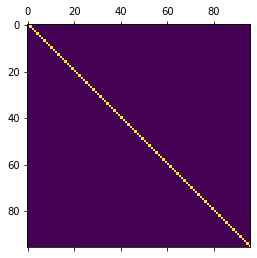

In [32]:
plt.matshow(np.imag(Z2))

## 4 wires in 3D cluster CNOT gate (in x-direction)

In [93]:
r = 0.5
# r = 2.5
bs_1, bs_2, bs_3 = 1, 6, 6*8
num_modes = bs_3*2

Z = np.identity(num_modes*2)*np.exp(-2*r)*1j

Z = transform_Z(epr_symplectic(), Z)

bipartition = identify_bipartition(Z) # Identify modes to be transformed for H-graph to Approximate CV cluster state  (ACVCS) conversion

S_h2c = generate_S_h2c(bipartition) # Symplectic matrix for H-graph -> ACVCS

Z = transform_Z(S_h2c, Z) # Adjacency matrix for ACVCS for EPR state

Z1 = transform_Z(cluster_symplectic(bs_1), Z)

Z2 = transform_Z(cluster_symplectic(bs_1, bs_2+1), Z)

In [94]:
A = np.block([[np.zeros((4,4)), np.zeros((4,np.shape(Z2)[0]))],[np.zeros((np.shape(Z2)[0],4)),Z2]])

bs3_block = np.diag(np.ones(num_modes*2))

for i in range(num_modes):
    if 2*i+1+(2*(bs_3+7)-1) < num_modes*2:
        bs3_block[2*i+1,2*i+1] = 1/np.sqrt(2)
        bs3_block[2*i+1,2*i+1+(2*(bs_3+7)-1)] = -1/np.sqrt(2)
        bs3_block[2*i+1+(2*(bs_3+7)-1),2*i+1] = 1/np.sqrt(2)
        bs3_block[2*i+1+(2*(bs_3+7)-1),2*i+1+(2*(bs_3+7)-1)] = 1/np.sqrt(2)

bs3_block = np.block([
    [np.identity(4), np.zeros((4,np.shape(bs3_block)[0]))],[np.zeros((np.shape(bs3_block)[0],4)),bs3_block]
])

S_bs3= np.block([[bs3_block, np.zeros(np.shape(bs3_block))],[np.zeros(np.shape(bs3_block)), bs3_block]]) 

S_cz = np.block([
    [np.identity(np.shape(A)[0]), np.zeros(np.shape(A))],
    [A, np.identity(np.shape(A)[0])]
])

B = np.identity(np.shape(A)[0])
B[0][0] = 1/np.sqrt(2)
B[44][44] = 1/np.sqrt(2)
B[0][44] = -1/np.sqrt(2)
B[44][0] = 1/np.sqrt(2)

B[1][1] = 1/np.sqrt(2)
B[48][48] = 1/np.sqrt(2)
B[1][48] = -1/np.sqrt(2)
B[48][1] = 1/np.sqrt(2)

B[2][2] = 1/np.sqrt(2)
B[68][68] = 1/np.sqrt(2)
B[2][68] = -1/np.sqrt(2)
B[68][2] = 1/np.sqrt(2)

B[3][3] = 1/np.sqrt(2)
B[72][72] = 1/np.sqrt(2)
B[3][72] = -1/np.sqrt(2)
B[72][3] = 1/np.sqrt(2)

S_bs = np.block([
    [B, np.zeros(np.shape(B))],
    [np.zeros(np.shape(B)), B]
])

pi4_rotations_temp = [13,14,21,22,25,26,33,34,37,38,45,46,49,50,57,58,61,62,69,70,73,74,81,82,15,28,19,32,63,76,67,80]
pi4_rotations_temp.extend([i+bs_3*2 for i in pi4_rotations_temp])

pi4_minus_rotations_temp = [17,18,29,30,41,42,53,54,65,66,77,78,39,52,43,56]
pi4_minus_rotations_temp.extend([i+bs_3*2 for i in pi4_minus_rotations_temp])

x_meas_temp = [0,11,12,23,24,35,36,47,48,59,60,71,72,83,84,95]
x_meas_temp.extend([i+bs_3*2 for i in [0,11,12,23,24,35,36,47,48,59,60,71,72,83,84,95]])
x_meas_temp.extend([16,20,75,79,112,116,171,175])
x_meas_temp.extend(range(1,12))
x_meas_temp.extend(range(85,96))
x_meas_temp.extend(range(96,107))
x_meas_temp.extend(range(180,191))

pi4_rotations = [i+4 for i in pi4_rotations_temp]
pi4_minus_rotations = [i+4 for i in pi4_minus_rotations_temp]
x_meas = [i+4 for i in x_meas_temp]

pi4_rotations.sort()
pi4_minus_rotations.sort()
x_meas.sort()

c = np.zeros(np.shape(A))
s = np.zeros(np.shape(A))

for i in pi4_rotations:
    c[i][i]=np.cos(np.pi/4)
    s[i][i]=np.sin(np.pi/4)

for i in pi4_minus_rotations:
    c[i][i]=np.cos(-np.pi/4)
    s[i][i]=np.sin(-np.pi/4)

for i in x_meas:
    c[i][i]=np.cos(0)
    s[i][i]=np.sin(0)

# t = 1/2*np.tanh(2*r)
t = 1/2

c[0][0]=np.cos(np.pi/8)
c[1][1]=np.cos(np.pi/8)
c[2][2]=np.cos(np.arctan(1/t))
c[3][3]=np.cos(np.arctan(1/t))
c[44][44]=np.cos(-3*np.pi/8)
c[48][48]=np.cos(-3*np.pi/8)
c[68][68]=np.cos(-np.arctan(1/t))
c[72][72]=np.cos(-np.arctan(1/t))


s[0][0]=np.sin(np.pi/8)
s[1][1]=np.sin(np.pi/8)
s[2][2]=np.sin(np.arctan(1/t))
s[3][3]=np.sin(np.arctan(1/t))
s[44][44]=np.sin(-3*np.pi/8)
s[48][48]=np.sin(-3*np.pi/8)
s[68][68]=np.sin(-np.arctan(1/t))
s[72][72]=np.sin(-np.arctan(1/t))

c[31][31]=np.cos(np.pi/4)
c[35][35]=np.cos(np.pi/4)
c[55][55]=np.cos(np.arctan(1/t))
c[59][59]=np.cos(np.arctan(1/t))
c[44+bs_3*2][44+bs_3*2]=np.cos(-np.pi/4-np.arctan(1/2))
c[48+bs_3*2][48+bs_3*2]=np.cos(-np.pi/4-np.arctan(1/2))
c[68+bs_3*2][68+bs_3*2]=np.cos(-np.arctan(1/t))
c[72+bs_3*2][72+bs_3*2]=np.cos(-np.arctan(1/t))


s[31][31]=np.sin(np.pi/4)
s[35][35]=np.sin(np.pi/4)
s[55][55]=np.sin(np.arctan(1/t))
s[59][59]=np.sin(np.arctan(1/t))
s[44+bs_3*2][44+bs_3*2]=np.sin(-np.pi/4-np.arctan(1/2))
s[48+bs_3*2][48+bs_3*2]=np.sin(-np.pi/4-np.arctan(1/2))
s[68+bs_3*2][68+bs_3*2]=np.sin(-np.arctan(1/t))
s[72+bs_3*2][72+bs_3*2]=np.sin(-np.arctan(1/t))

c[31+bs_3*2][31+bs_3*2]=1
c[35+bs_3*2][35+bs_3*2]=1
c[55+bs_3*2][55+bs_3*2]=1
c[59+bs_3*2][59+bs_3*2]=1

c[33][33]=np.cos(-np.pi/4+np.arctan(1/2))
c[142][142]=np.cos(-np.pi/4+np.arctan(1/2))
s[33][33]=np.sin(-np.pi/4+np.arctan(1/2))
s[142][142]=np.sin(-np.pi/4+np.arctan(1/2))



S_r = np.block([
    [c, s],
    [-s, c]
])

S = S_r@S_bs@S_bs3@S_cz

U = np.vstack([
    S[0:127,4:196],
    S[128:131,4:196],
    S[132:151,4:196],
    S[152:155,4:196],
    S[156:196,4:196]

])

V = np.vstack([
    np.hstack((S[0:127,0:4],S[0:127,196:])),
    np.hstack((S[128:131,0:4],S[128:131,196:])),
    np.hstack((S[132:151,0:4],S[132:151,196:])),
    np.hstack((S[152:155,0:4],S[152:155,196:])),
    np.hstack((S[156:196,0:4],S[156:196,196:]))
])

Z = np.vstack([
    np.hstack((S[127,0:4],S[127,196:])),
    np.hstack((S[131,0:4],S[131,196:])),
    np.hstack((S[151,0:4],S[151,196:])),
    np.hstack((S[155,0:4],S[155,196:])),
    np.hstack((S[127+196,0:4],S[127+196,196:])),
    np.hstack((S[131+196,0:4],S[131+196,196:])),
    np.hstack((S[151+196,0:4],S[151+196,196:])),
    np.hstack((S[155+196,0:4],S[155+196,196:]))
])

Y = np.vstack([
    S[127,4:196],
    S[131,4:196],
    S[151,4:196],
    S[155,4:196],
    S[127+196,4:196],
    S[131+196,4:196],
    S[151+196,4:196],
    S[155+196,4:196],
])

M = Z - Y@np.linalg.inv(U)@V

In [95]:
round_matrix(M[:8,:8])

array([[ 224.93,  140.28,    0.  ,    0.  , -203.14,   51.5 ,    0.  ,
           0.  ],
       [ 140.28,  224.93,    0.  ,    0.  ,   51.5 , -203.14,    0.  ,
           0.  ],
       [   0.  ,    0.  ,  149.88,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ],
       [   0.  ,    0.  ,    0.  ,  149.88,    0.  ,    0.  ,    0.  ,
           0.  ],
       [ 158.64,  -96.71,    0.  ,    0.  ,  180.43,   95.08,    0.  ,
           0.  ],
       [ -96.71,  158.64,    0.  ,    0.  ,   95.08,  180.43,    0.  ,
           0.  ],
       [   0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,  602.53,
           0.  ],
       [   0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
         602.53]])

In [96]:
noise = []
for i in range(np.shape(M)[0]):
    noise_temp = 0
    for j in range(np.shape(M)[0],np.shape(M)[1]):
        noise_temp += abs(M[i][j])**2
    noise.append(noise_temp)

noise

[156581.21412213426,
 156581.2141221367,
 139004.84359323003,
 139004.84359323987,
 127729.80639316014,
 127729.80639316233,
 139700.41428448167,
 139700.4142844916]

## 4 wires in 3D cluster CNOT gate (in y-direction)

In [90]:
r = 10
# r = 2.5
bs_1, bs_2, bs_3 = 1, 6, 6*8
num_modes = bs_3*2

Z = np.identity(num_modes*2)*np.exp(-2*r)*1j

Z = transform_Z(epr_symplectic(), Z)

bipartition = identify_bipartition(Z) # Identify modes to be transformed for H-graph to Approximate CV cluster state  (ACVCS) conversion

S_h2c = generate_S_h2c(bipartition) # Symplectic matrix for H-graph -> ACVCS

Z = transform_Z(S_h2c, Z) # Adjacency matrix for ACVCS for EPR state

Z1 = transform_Z(cluster_symplectic(bs_1), Z)

Z2 = transform_Z(cluster_symplectic(bs_1, bs_2+1), Z)

In [91]:
A = np.block([[np.zeros((4,4)), np.zeros((4,np.shape(Z2)[0]))],[np.zeros((np.shape(Z2)[0],4)),Z2]])

bs3_block = np.diag(np.ones(num_modes*2))

for i in range(num_modes):
    if 2*i+1+(2*(bs_3+7)-1) < num_modes*2:
        bs3_block[2*i+1,2*i+1] = 1/np.sqrt(2)
        bs3_block[2*i+1,2*i+1+(2*(bs_3+7)-1)] = -1/np.sqrt(2)
        bs3_block[2*i+1+(2*(bs_3+7)-1),2*i+1] = 1/np.sqrt(2)
        bs3_block[2*i+1+(2*(bs_3+7)-1),2*i+1+(2*(bs_3+7)-1)] = 1/np.sqrt(2)

bs3_block = np.block([
    [np.identity(4), np.zeros((4,np.shape(bs3_block)[0]))],[np.zeros((np.shape(bs3_block)[0],4)),bs3_block]
])

S_bs3= np.block([[bs3_block, np.zeros(np.shape(bs3_block))],[np.zeros(np.shape(bs3_block)), bs3_block]]) 

S_cz = np.block([
    [np.identity(np.shape(A)[0]), np.zeros(np.shape(A))],
    [A, np.identity(np.shape(A)[0])]
])

B = np.identity(np.shape(A)[0])
B[0][0] = 1/np.sqrt(2)
B[44][44] = 1/np.sqrt(2)
B[0][44] = -1/np.sqrt(2)
B[44][0] = 1/np.sqrt(2)

B[1][1] = 1/np.sqrt(2)
B[48][48] = 1/np.sqrt(2)
B[1][48] = -1/np.sqrt(2)
B[48][1] = 1/np.sqrt(2)

B[2][2] = 1/np.sqrt(2)
B[68][68] = 1/np.sqrt(2)
B[2][68] = -1/np.sqrt(2)
B[68][2] = 1/np.sqrt(2)

B[3][3] = 1/np.sqrt(2)
B[72][72] = 1/np.sqrt(2)
B[3][72] = -1/np.sqrt(2)
B[72][3] = 1/np.sqrt(2)

S_bs = np.block([
    [B, np.zeros(np.shape(B))],
    [np.zeros(np.shape(B)), B]
])

pi4_rotations_temp = [13,14,21,22,25,26,33,34,37,38,45,46,49,50,57,58,61,62,69,70,73,74,81,82,15,28,19,32,63,76,67,80]
pi4_rotations_temp.extend([i+bs_3*2 for i in pi4_rotations_temp])

pi4_minus_rotations_temp = [17,18,29,30,41,42,53,54,65,66,77,78,39,52,43,56]
pi4_minus_rotations_temp.extend([i+bs_3*2 for i in pi4_minus_rotations_temp])

x_meas_temp = [0,11,12,23,24,35,36,47,48,59,60,71,72,83,84,95]
x_meas_temp.extend([i+bs_3*2 for i in [0,11,12,23,24,35,36,47,48,59,60,71,72,83,84,95]])
x_meas_temp.extend([16,20,75,79,112,116,171,175])
x_meas_temp.extend(range(1,12))
x_meas_temp.extend(range(85,96))
x_meas_temp.extend(range(96,107))
x_meas_temp.extend(range(180,191))

pi4_rotations = [i+4 for i in pi4_rotations_temp]
pi4_minus_rotations = [i+4 for i in pi4_minus_rotations_temp]
x_meas = [i+4 for i in x_meas_temp]

pi4_rotations.sort()
pi4_minus_rotations.sort()
x_meas.sort()

c = np.zeros(np.shape(A))
s = np.zeros(np.shape(A))

for i in pi4_rotations:
    c[i][i]=np.cos(np.pi/4)
    s[i][i]=np.sin(np.pi/4)

for i in pi4_minus_rotations:
    c[i][i]=np.cos(-np.pi/4)
    s[i][i]=np.sin(-np.pi/4)

for i in x_meas:
    c[i][i]=np.cos(0)
    s[i][i]=np.sin(0)

# t = 1/r*np.tanh(2*r)
t = 1

c[0][0]=np.cos(np.pi/8)
c[1][1]=np.cos(-np.arctan(1/t))
c[2][2]=np.cos(np.pi/8)
c[3][3]=np.cos(np.arctan(1/t))
c[44][44]=np.cos(-3*np.pi/8)
c[48][48]=np.cos(np.arctan(1/t))
c[68][68]=np.cos(-3*np.pi/8)
c[72][72]=np.cos(-np.arctan(1/t))


s[0][0]=np.sin(np.pi/8)
s[1][1]=np.sin(-np.arctan(1/t))
s[2][2]=np.sin(np.pi/8)
s[3][3]=np.sin(np.arctan(1/t))
s[44][44]=np.sin(-3*np.pi/8)
s[48][48]=np.sin(np.arctan(1/t))
s[68][68]=np.sin(-3*np.pi/8)
s[72][72]=np.sin(-np.arctan(1/t))

c[31][31]=np.cos(np.pi/4)
c[35][35]=np.cos(-np.arctan(1/t))
c[55][55]=np.cos(np.pi/4)
c[59][59]=np.cos(np.arctan(1/t))
c[44+bs_3*2][44+bs_3*2]=np.cos(-np.pi/4-np.arctan(1/2))
c[48+bs_3*2][48+bs_3*2]=np.cos(np.arctan(1/t))
c[68+bs_3*2][68+bs_3*2]=np.cos(-np.pi/4-np.arctan(1/2))
c[72+bs_3*2][72+bs_3*2]=np.cos(-np.arctan(1/t))


s[31][31]=np.sin(np.pi/4)
s[35][35]=np.sin(-np.arctan(1/t))
s[55][55]=np.sin(np.pi/4)
s[59][59]=np.sin(np.arctan(1/t))
s[44+bs_3*2][44+bs_3*2]=np.sin(-np.pi/4-np.arctan(1/2))
s[48+bs_3*2][48+bs_3*2]=np.sin(np.arctan(1/t))
s[68+bs_3*2][68+bs_3*2]=np.sin(-np.pi/4-np.arctan(1/2))
s[72+bs_3*2][72+bs_3*2]=np.sin(-np.arctan(1/t))

c[31+bs_3*2][31+bs_3*2]=1
c[35+bs_3*2][35+bs_3*2]=1
c[55+bs_3*2][55+bs_3*2]=1
c[59+bs_3*2][59+bs_3*2]=1

c[43][43]=np.cos(-np.pi/4+np.arctan(1/2))
c[152][152]=np.cos(-np.pi/4+np.arctan(1/2))
s[43][43]=np.sin(-np.pi/4+np.arctan(1/2))
s[152][152]=np.sin(-np.pi/4+np.arctan(1/2))

S_r = np.block([
    [c, s],
    [-s, c]
])

S = S_r@S_bs@S_bs3@S_cz

U = np.vstack([
    S[0:127,4:196],
    S[128:131,4:196],
    S[132:151,4:196],
    S[152:155,4:196],
    S[156:196,4:196]

])

V = np.vstack([
    np.hstack((S[0:127,0:4],S[0:127,196:])),
    np.hstack((S[128:131,0:4],S[128:131,196:])),
    np.hstack((S[132:151,0:4],S[132:151,196:])),
    np.hstack((S[152:155,0:4],S[152:155,196:])),
    np.hstack((S[156:196,0:4],S[156:196,196:]))
])

Z = np.vstack([
    np.hstack((S[127,0:4],S[127,196:])),
    np.hstack((S[131,0:4],S[131,196:])),
    np.hstack((S[151,0:4],S[151,196:])),
    np.hstack((S[155,0:4],S[155,196:])),
    np.hstack((S[127+196,0:4],S[127+196,196:])),
    np.hstack((S[131+196,0:4],S[131+196,196:])),
    np.hstack((S[151+196,0:4],S[151+196,196:])),
    np.hstack((S[155+196,0:4],S[155+196,196:]))
])

Y = np.vstack([
    S[127,4:196],
    S[131,4:196],
    S[151,4:196],
    S[155,4:196],
    S[127+196,4:196],
    S[131+196,4:196],
    S[151+196,4:196],
    S[155+196,4:196],
])

M = Z - Y@np.linalg.inv(U)@V

In [92]:
round_matrix(M[:8,:8])

array([[ 0.71,  0.  , -0.71,  0.  , -0.71,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [-0.71,  0.  ,  0.71,  0.  ,  0.  ,  0.  , -0.71,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.71,  0.  ,  0.71,  0.  ,  0.71,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.71,  0.  ,  0.71,  0.  ,  0.  ,  0.  ,  0.71,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ]])

In [486]:
noise = []
for i in range(np.shape(M)[0]):
    noise_temp = 0
    for j in range(np.shape(M)[0],np.shape(M)[1]):
        noise_temp += M[i][j]**2
    noise.append(noise_temp)

noise

[(10.000000000000009+8.244614489754142e-09j),
 (8.000000000000004+1.6489228979508493e-08j),
 (10.000000000000014+8.244614489754207e-09j),
 (8.000000000000004+1.648922897950852e-08j),
 (9.99999999999999-4.1223072448771126e-08j),
 (7.99999999999999+1.648922897950838e-08j),
 (9.999999999999993-4.1223072448771166e-08j),
 (7.999999999999991+1.6489228979508446e-08j)]

## 4 wires in 3D cluster identity gate (2 steps)

In [452]:
r = 10
# r = 2.5
bs_1, bs_2, bs_3 = 1, 6, 6*8
num_modes = bs_3*2

Z = np.identity(num_modes*2)*np.exp(-2*r)*1j

Z = transform_Z(epr_symplectic(), Z)

bipartition = identify_bipartition(Z) # Identify modes to be transformed for H-graph to Approximate CV cluster state  (ACVCS) conversion

S_h2c = generate_S_h2c(bipartition) # Symplectic matrix for H-graph -> ACVCS

Z = transform_Z(S_h2c, Z) # Adjacency matrix for ACVCS for EPR state

Z1 = transform_Z(cluster_symplectic(bs_1), Z)

Z2 = transform_Z(cluster_symplectic(bs_1, bs_2+1), Z)

In [453]:
A = np.block([[np.zeros((4,4)), np.zeros((4,np.shape(Z2)[0]))],[np.zeros((np.shape(Z2)[0],4)),Z2]])

bs3_block = np.diag(np.ones(num_modes*2))

for i in range(num_modes):
    if 2*i+1+(2*(bs_3+7)-1) < num_modes*2:
        bs3_block[2*i+1,2*i+1] = 1/np.sqrt(2)
        bs3_block[2*i+1,2*i+1+(2*(bs_3+7)-1)] = -1/np.sqrt(2)
        bs3_block[2*i+1+(2*(bs_3+7)-1),2*i+1] = 1/np.sqrt(2)
        bs3_block[2*i+1+(2*(bs_3+7)-1),2*i+1+(2*(bs_3+7)-1)] = 1/np.sqrt(2)

bs3_block = np.block([
    [np.identity(4), np.zeros((4,np.shape(bs3_block)[0]))],[np.zeros((np.shape(bs3_block)[0],4)),bs3_block]
])

S_bs3= np.block([[bs3_block, np.zeros(np.shape(bs3_block))],[np.zeros(np.shape(bs3_block)), bs3_block]]) 

S_cz = np.block([
    [np.identity(np.shape(A)[0]), np.zeros(np.shape(A))],
    [A, np.identity(np.shape(A)[0])]
])

B = np.identity(np.shape(A)[0])
B[0][0] = 1/np.sqrt(2)
B[44][44] = 1/np.sqrt(2)
B[0][44] = -1/np.sqrt(2)
B[44][0] = 1/np.sqrt(2)

B[1][1] = 1/np.sqrt(2)
B[48][48] = 1/np.sqrt(2)
B[1][48] = -1/np.sqrt(2)
B[48][1] = 1/np.sqrt(2)

B[2][2] = 1/np.sqrt(2)
B[68][68] = 1/np.sqrt(2)
B[2][68] = -1/np.sqrt(2)
B[68][2] = 1/np.sqrt(2)

B[3][3] = 1/np.sqrt(2)
B[72][72] = 1/np.sqrt(2)
B[3][72] = -1/np.sqrt(2)
B[72][3] = 1/np.sqrt(2)

S_bs = np.block([
    [B, np.zeros(np.shape(B))],
    [np.zeros(np.shape(B)), B]
])

pi4_rotations_temp = [13,14,21,22,25,26,33,34,37,38,45,46,49,50,57,58,61,62,69,70,73,74,81,82,15,28,19,32,63,76,67,80]
pi4_rotations_temp.extend([i+bs_3*2 for i in pi4_rotations_temp])

pi4_minus_rotations_temp = [17,18,29,30,41,42,53,54,65,66,77,78,39,52,43,56]
pi4_minus_rotations_temp.extend([i+bs_3*2 for i in pi4_minus_rotations_temp])

x_meas_temp = [0,11,12,23,24,35,36,47,48,59,60,71,72,83,84,95]
x_meas_temp.extend([i+bs_3*2 for i in [0,11,12,23,24,35,36,47,48,59,60,71,72,83,84,95]])
x_meas_temp.extend([16,20,75,79,112,116,171,175])
x_meas_temp.extend(range(1,12))
x_meas_temp.extend(range(85,96))
x_meas_temp.extend(range(96,107))
x_meas_temp.extend(range(180,191))

pi4_rotations = [i+4 for i in pi4_rotations_temp]
pi4_minus_rotations = [i+4 for i in pi4_minus_rotations_temp]
x_meas = [i+4 for i in x_meas_temp]

pi4_rotations.sort()
pi4_minus_rotations.sort()
x_meas.sort()

c = np.zeros(np.shape(A))
s = np.zeros(np.shape(A))

for i in pi4_rotations:
    c[i][i]=np.cos(np.pi/4)
    s[i][i]=np.sin(np.pi/4)

for i in pi4_minus_rotations:
    c[i][i]=np.cos(-np.pi/4)
    s[i][i]=np.sin(-np.pi/4)

for i in x_meas:
    c[i][i]=np.cos(0)
    s[i][i]=np.sin(0)

# t = 1/r*np.tanh(2*r)
t = 1

c[0][0]=np.cos(-np.arctan(1/t))
c[1][1]=np.cos(-np.arctan(1/t))
c[2][2]=np.cos(np.arctan(1/t))
c[3][3]=np.cos(np.arctan(1/t))
c[44][44]=np.cos(np.arctan(1/t))
c[48][48]=np.cos(np.arctan(1/t))
c[68][68]=np.cos(-np.arctan(1/t))
c[72][72]=np.cos(-np.arctan(1/t))


s[0][0]=np.sin(-np.arctan(1/t))
s[1][1]=np.sin(-np.arctan(1/t))
s[2][2]=np.sin(np.arctan(1/t))
s[3][3]=np.sin(np.arctan(1/t))
s[44][44]=np.sin(np.arctan(1/t))
s[48][48]=np.sin(np.arctan(1/t))
s[68][68]=np.sin(-np.arctan(1/t))
s[72][72]=np.sin(-np.arctan(1/t))

c[31][31]=np.cos(-np.arctan(1/t))
c[35][35]=np.cos(-np.arctan(1/t))
c[55][55]=np.cos(np.arctan(1/t))
c[59][59]=np.cos(np.arctan(1/t))
c[44+bs_3*2][44+bs_3*2]=np.cos(np.arctan(1/t))
c[48+bs_3*2][48+bs_3*2]=np.cos(np.arctan(1/t))
c[68+bs_3*2][68+bs_3*2]=np.cos(-np.arctan(1/t))
c[72+bs_3*2][72+bs_3*2]=np.cos(-np.arctan(1/t))


s[31][31]=np.sin(-np.arctan(1/t))
s[35][35]=np.sin(-np.arctan(1/t))
s[55][55]=np.sin(np.arctan(1/t))
s[59][59]=np.sin(np.arctan(1/t))
s[44+bs_3*2][44+bs_3*2]=np.sin(np.arctan(1/t))
s[48+bs_3*2][48+bs_3*2]=np.sin(np.arctan(1/t))
s[68+bs_3*2][68+bs_3*2]=np.sin(-np.arctan(1/t))
s[72+bs_3*2][72+bs_3*2]=np.sin(-np.arctan(1/t))

c[31+bs_3*2][31+bs_3*2]=1
c[35+bs_3*2][35+bs_3*2]=1
c[55+bs_3*2][55+bs_3*2]=1
c[59+bs_3*2][59+bs_3*2]=1



S_r = np.block([
    [c, s],
    [-s, c]
])

S = S_r@S_bs@S_bs3@S_cz

U = np.vstack([
    S[0:127,4:196],
    S[128:131,4:196],
    S[132:151,4:196],
    S[152:155,4:196],
    S[156:196,4:196]

])

V = np.vstack([
    np.hstack((S[0:127,0:4],S[0:127,196:])),
    np.hstack((S[128:131,0:4],S[128:131,196:])),
    np.hstack((S[132:151,0:4],S[132:151,196:])),
    np.hstack((S[152:155,0:4],S[152:155,196:])),
    np.hstack((S[156:196,0:4],S[156:196,196:]))
])

Z = np.vstack([
    np.hstack((S[127,0:4],S[127,196:])),
    np.hstack((S[131,0:4],S[131,196:])),
    np.hstack((S[151,0:4],S[151,196:])),
    np.hstack((S[155,0:4],S[155,196:])),
    np.hstack((S[127+196,0:4],S[127+196,196:])),
    np.hstack((S[131+196,0:4],S[131+196,196:])),
    np.hstack((S[151+196,0:4],S[151+196,196:])),
    np.hstack((S[155+196,0:4],S[155+196,196:]))
])

Y = np.vstack([
    S[127,4:196],
    S[131,4:196],
    S[151,4:196],
    S[155,4:196],
    S[127+196,4:196],
    S[131+196,4:196],
    S[151+196,4:196],
    S[155+196,4:196],
])

M = Z - Y@np.linalg.inv(U)@V

In [454]:
round_matrix(M[:8,:8])

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [455]:
noise = []
for i in range(np.shape(M)[0]):
    noise_temp = 0
    for j in range(np.shape(M)[0],np.shape(M)[1]):
        noise_temp += M[i][j]**2
    noise.append(noise_temp)

noise

[(8.000000000000007-1.6489228979508486e-08j),
 (8.000000000000009+1.648922897950848e-08j),
 (8.00000000000001-1.648922897950857e-08j),
 (8.00000000000001+1.6489228979508546e-08j),
 (7.99999999999999-1.648922897950842e-08j),
 (7.999999999999993+1.6489228979508367e-08j),
 (7.9999999999999885-1.6489228979508374e-08j),
 (7.999999999999993+1.6489228979508453e-08j)]